In [32]:
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
sys.path.append('/home/kal/K27act_models/convolution_model/')
sys.path.append('/home/kal/K27act_models/cg_model/')
sys.path.append('/home/thouis/basenji_embeddings')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tf_memory_limit
from zinb import ZINB
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from keras.utils import plot_model

import pandas as pd
import numpy as np
import itertools
import sequence
import helper
import viz_sequence
import ucscgenome
from tqdm import tqdm
import time
import datagen
import pickle

from keras.models import Model
from keras.layers import Input, Dense, SpatialDropout1D, Conv1D, Lambda
from keras.optimizers import RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
#load in the DNA
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

In [5]:
# load in ATAC data
atac_path = '/home/kal/K27act_models/GM_data/ATAC/atac_average.hdf5'
atac = h5py.File(atac_path, 'r')

In [8]:
# load in peaks data
peaks_path = '/home/kal/K27act_models/GM_data/merged_annotated.bed'
peaks = pd.read_table(peaks_path)
peaks.columns='chr narrowstart narrowend name score atac k27act'.split()

peaks['start'] = (peaks['narrowend'] + peaks['narrowstart'])//2 - 512
peaks['end'] = (peaks['narrowend'] + peaks['narrowstart'])//2 + 512

In [9]:
# preproces the data
for idx, row in tqdm(peaks.iterrows(), total=len(peaks)):
    peaks.set_value(idx, 'nucs', genome[row.chr][row.start:row.end])
    #mini.set_value(idx, 'coverage', atac[row.chr][row.start:row.end])
    
columns='chr start end name score atac k27act nucs'.split()
peaks.to_csv('/home/kal/K27act_models/GM_data/k27act_training_regions.bed', columns=columns, header=None, index=False, sep='\t')

100%|██████████| 167190/167190 [00:41<00:00, 4061.95it/s]


In [10]:
# load in preprocessed data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
peaks.columns='chr start end name score atac k27act nucs'.split()

In [11]:
# facts about the data
num_training_samples = len(peaks[(peaks.chr != 'chr8')])
print('{} training samples'.format(num_training_samples))

num_testing_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 0)])
print('{} testing samples'.format(num_testing_samples))

num_validaiton_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)])
print('{} validation samples'.format(num_validaiton_samples))

160363 training samples
3413 testing samples
3414 validation samples


In [45]:
# directory stuff
out_dir = '/home/kal/K27act_models/convolution_model/'
timestr = time.strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(out_dir, timestr + '_fold_pwm')
os.makedirs(out_path)
# make a file system
weights_path = os.path.join(out_path, 'intermediate_weights')
os.makedirs(weights_path)
history_path = os.path.join(out_path, 'history')
os.makedirs(history_path)

In [46]:
# MODEL
batch_size=32
seqs = Input(batch_shape=(batch_size, 1024, 5))

def add_RC(x):
    RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][::-1]], axis=2)
    return K.concatenate([x, RC], axis=0)
def add_RC_shape(s):
    return 2*s[0], s[1], s[2]

rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)(seqs)
conv = Conv1D(128, 32, name='conv_in')(rc)
dense = Dense(1)(conv)

def max_by_direction(x):
    forward_max = K.max(x[:x.shape[0]//2, :, :], axis=1)
    reverse_max = K.max(x[x.shape[0]//2:, ::-1, :], axis=1)
    return K.maximum(forward_max, reverse_max)
def max_by_direction_shape(s):
    return s[0]//2, 1

wide_scan = Conv1D(1, 128, use_bias=False, kernel_initializer='ones', trainable=False, name='wide_scan', padding='valid')
predictions = Lambda(max_by_direction, name='max_by_direciton', output_shape=max_by_direction_shape)(wide_scan(dense))
model = Model(inputs=seqs, outputs=predictions)

#plot model
plot_model(model, to_file=os.path.join(out_path, 'model.png'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (32, 1024, 5)             0         
_________________________________________________________________
add_rc (Lambda)              (64, 1024, 5)             0         
_________________________________________________________________
conv_in (Conv1D)             (64, 993, 128)            20608     
_________________________________________________________________
dense_4 (Dense)              (64, 993, 1)              129       
_________________________________________________________________
wide_scan (Conv1D)           (64, 866, 1)              128       
_________________________________________________________________
max_by_direciton (Lambda)    (32, 1)                   0         
Total params: 20,865
Trainable params: 20,737
Non-trainable params: 128
_________________________________________________________________


In [47]:
from keras.optimizers import RMSprop, SGD, Adam

opt = RMSprop(lr=1e-5)
model.compile(optimizer=opt, loss='mean_squared_error') 

early_stop = EarlyStopping(monitor='val_loss', patience=100)
filepath = os.path.join(weights_path, 'weights-{epoch:02d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

losses = model.fit_generator(datagen.batch_gen(peaks, mode='train'), steps_per_epoch=num_training_samples//batch_size, 
                             epochs=20, callbacks=[early_stop, checkpoint], validation_data=datagen.batch_gen(peaks,mode='val'), 
                             validation_steps=num_validaiton_samples//batch_size, verbose=2)


val_hist = losses.history['val_loss']
train_hist = losses.history['loss']

Epoch 1/20
 - 396s - loss: 339.7576 - val_loss: 191.6854

Epoch 00001: val_loss improved from inf to 191.68539, saving model to /home/kal/K27act_models/convolution_model/20180709_153050_fold_pwm/intermediate_weights/weights-01-191.685.hdf5
Epoch 2/20
 - 391s - loss: 150.3646 - val_loss: 66.9433

Epoch 00002: val_loss improved from 191.68539 to 66.94328, saving model to /home/kal/K27act_models/convolution_model/20180709_153050_fold_pwm/intermediate_weights/weights-02-66.943.hdf5
Epoch 3/20
 - 388s - loss: 69.7547 - val_loss: 28.3171

Epoch 00003: val_loss improved from 66.94328 to 28.31707, saving model to /home/kal/K27act_models/convolution_model/20180709_153050_fold_pwm/intermediate_weights/weights-03-28.317.hdf5
Epoch 4/20
 - 393s - loss: 59.9314 - val_loss: 24.8946

Epoch 00004: val_loss improved from 28.31707 to 24.89461, saving model to /home/kal/K27act_models/convolution_model/20180709_153050_fold_pwm/intermediate_weights/weights-04-24.895.hdf5
Epoch 5/20
 - 385s - loss: 50.0863 

In [48]:
# final save
model.save(os.path.join(out_path, 'final_model.h5'))

In [49]:
# write out history
pickle.dump(losses.history, open(os.path.join(history_path, 'history.pk'), 'wb'))

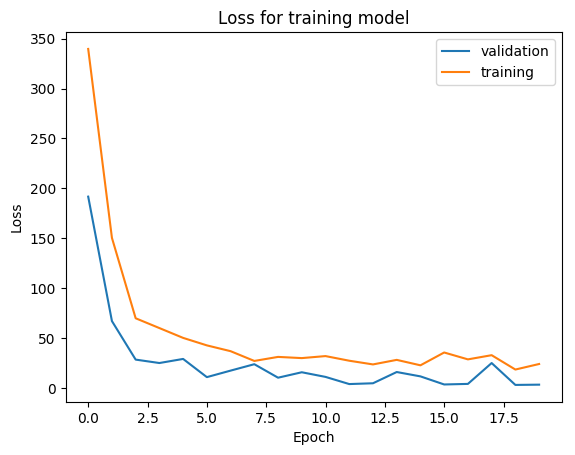

In [50]:
# look at loss
plt.plot(val_hist, label='validation')
plt.plot(train_hist, label='training')
plt.title('Loss for training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# look at kernels

# make a highlight map
from colour import Color

#what layers do we have to work with?
layer_dict = dict([(layer.name, layer) for layer in model.layers]) 
print(layer_dict.keys())

# plot weights from first layer neurons
#temp = .005
weight_array = layer_dict['conv_in'].get_weights()[0]
#create highlight dict - with sane maxs and mins
colors = list(Color("blue").range_to(Color("white"), 50))
[colors.append(c) for c in (Color("white").range_to(Color("red"), 51))]
top = np.amax(weight_array[:, 0, :])
bottom = np.amin(weight_array[:, 0, :])
    
# got throught the kernels
for idx in range(weight_array.shape[2]):
    weight = weight_array[:,:,idx]
    #get hightlights!
    color_weights = [int((x-bottom)/(top-bottom)*100) for x in weight[:,0]]
    highlight=dict()
    for i in range(len(weight)):
        w = color_weights[i]
        highlight[(colors[w].rgb[0],colors[w].rgb[1], colors[w].rgb[2], .3)] = [(i, i+1)]
    #plot things out
    kernel = sequence.Sequence(weight[:, 1:])
    plt.figure(figsize=(20,2))
    plt.title('ATAC weights and sequence for kernel {}'.format(idx))
    plt.plot(weight[:,0])
    plt.show()
    viz_sequence.plot_weights(kernel.seq, highlight=highlight)
